<a href="https://colab.research.google.com/github/DataScienceUB/DeepLearningMaster2019/blob/master/14.%20Uncertainty_and_Probabilistic_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning, uncertainty and probabilistic models.

Uncertaint predictions can be caused by several factors:



+ **Epistemic uncertainty**:  It corresponds to the uncertainty originated by the model.  It can be explained as to which extent is our model able to describe the distribution that generated the data.  In this case we can talk of two different types of uncertainties caused by whether the model has been trained with enough data, so it’s been able to learn the full distributionof the data, or whether the expressiveness of the model is able to capture the complexity of the distribution.  When using a expressive enough model, this type of uncertainty *can be reduced* by providing more samples during the training phase.

+ **Aleatoric uncertainty**:  In this case the uncertainty measured belongs to the data.   This uncertainty is inherent to the data and *can’t be reduced* by adding more data to the training process. There are two types of aleatoric uncertainty:

    + **Homoscedastic**:  It measures  the  level  of noise that is derived from the measurement process.  This uncertainty remains constant for all the data.
    + **Heteroscedastic**: It measures  the  level  of uncertainty  caused  by  the data itself.   
    
Different  types  of  uncertainty  must  be  measured in different ways.   

A neural network $f$ can be viewed as probabilistic model $p(y|x,w,D)$. For classification, $y$ is a set of classes and $p(y|x,w,D)$ is a categorical distribution. For regression, $y$ is a continuous variable and $p(y|x,w,D)$ is a Gaussian distribution.  Our goal  can be  to  **capture  the  distribution**  that  generated the outputs by means of a model with parameters $W$.

$$
p(y^* | x^*, D) = \int_W p(y^* | f_W(x^*))p(W|D)dW
$$

We can observe that the distribution of the output depends on two terms: one that depends on the application of the model to the input data, and a second one that is measuring how the model may  vary  depending  on  the  training  data.   

From this definition we can say that the first term is modeling the **aleatoric uncertainty**, as it is measuring  how  the  output  is distributed when the input is $x^*$,  and the second term is modeling the **epistemic uncertainty** as it is measuring the uncertainty induced by the parameters of the model.

## Epistemic Uncertainty

In  the  case  of  the epistemic uncertainty, let’s assume that we have trained model with parameters $W$ that produces an output $f_W(x)$.

In this case we can approximate the term $p(y∗|f_W(x∗))$ with a delta distribution fixed around the trained model $δ(y−f_W(x^∗))$, thus obtaining:

$$
p(y^* | x^*, D) = \int_W δ(y−f_W(x^∗))p(W|D)dW
$$

Then, we can compute the mean value of the output:

$$
\mathop{\mathbb{E}} (y^* | x^*, D) = \int_y \int_W δ(y−f_W(x^∗))p(W|D)dWdy 
$$

$$
= \int_y \int_W y δ(y−f_W(x^∗))p(W|D)dWdy  
$$

$$
=\int_W f_W(x^∗)p(W|D)dW
$$

If we assume that $W \sim \mathcal{N}(f_W, \sigma^2)$ we can approximate this integral by using Monte Carlo simulation, drawing samples from the distribution of the weights:

$$
\mathop{\mathbb{E}}(y^*|x^*, D) \approx \frac{1}{M}\sum_{j=1}^{M} f_{{W_{j}}}(x^*)
$$

Finaly we can calculate the corresponding variance:
$$
\mathop{\mathbb{Var}} (y^*) \approx \frac{1}{M}\sum_{j=1}^{M} f_{W_{j}}(x^*)^2 - \mathop{\mathbb{E}}(y^*|x^*, D)^2
$$

Which can be used as a measure of the **epistemic uncertainty**.

## Aleatoric Uncertainty

For obtaining the heteroscedastic uncertainty, we follow the same approach as in the epistemic case: we consider that we have a fixed model and we want to observe the variability of the term $p(y^*|f_W(x^*))$. 

We can assume that $y^* \sim \mathcal{N}(f^{{W}}(x^*), \sigma(x)^2)$, where $f^{{W}}(x^*)$ is one sample of the model and $\sigma(x)$ is a function that depends on the input data that will trained together with $f$.

In regression tasks, applying this approximation to the log likelihood adds an additional term to the loss that depends on $\sigma(x)$.

In classification tasks, this approximation is not as straightforward as in regression, as for classification there is already an uncertainty component due to the distribution of the probabilities when applying the softmax to the logits. 

In this scenario, we can apply the same assumption but to the logits space instead of the output directly:

$$\begin{split}
logits \sim \mathcal{N}(f_{{W}}(x^*), diag(\sigma(x)^2))  \\
p = softmax(logits) \\
y \sim Categorical(p)
\end{split}
$$

Here we can apply the reparametrization trick forcomputing the logits, $u$:

$$
\begin{split}
u \sim \mathcal{N}(f_{{W}}(x^*), diag(\sigma(x)^2))  \\
u = f_{{W}}(x^*) + \sqrt{diag(\sigma(x)^2)}* \epsilon\\
u = f_{{W}}(x^*) + diag(\sigma(x))* \epsilon, \epsilon\sim\mathcal{N}(0,1)
\end{split}
$$

And then apply Monte Carlo sampling to obtain the expectation of the probability:

$$
\mathop{\mathbb{E}}[p] = \frac{1}{M}\sum^{M}_{m=1}softmax(u^{m})
$$

When applied to a crossentropy loss we have that:

$$
\begin{align}
\ell(W) & = \frac{1}{N}\sum^{N}_{i=1}-\frac{1} {C}\sum^{C}_{c=1}y_{i,c}\log{(p_{i,c})}  \\
& = \frac{1}{N}\sum^{N}_{i=1}-\frac{1}{C}\sum^{C}_{c=1}y_{i,c}\log{\frac{1}{M}\sum^{M}_{m=1}softmax(u^{m})}\\
& = \frac{1}{N}\sum^{N}_{i=1}-\frac{1}{C}\sum^{C}_{c=1}y_{i,c}\log{\frac{1}{M}\sum^{M}_{m=1}\frac{\exp{u^{m}_{i,c,m}}}{\sum^{C}_{c{}'=1}\exp{u^{m}_{i,c{}',m}}}} \\
& =  \frac{1}{N}\sum^{N}_{i=1}-\frac{1}{C}\sum^{C}_{c=1}y_{i,c}\log{\sum^{M}_{m=1}\exp({u^{m}_{i,c,m}}} - \log{\sum^{C}_{c'=1}\exp{u^{m}_{i,c',m}})}-\log{M} \\
\end{align} 
$$

Where $N$ is the number of examples per batch, $C$ is the number of classes and $M$ is the number of Monte Carlo samples taken.

Once trained, the sigmas can be used to obtain a measure of the aleatoric uncertainty associated to the input by calculating the mean variance of the logits:

$$
\begin{align}
\mathop{\mathbb{U}} & = \frac{1}{C}\sum^{C}_{c=1}var[p_{c}] \\
&= \frac{1}{C}\sum^{C}_{c=1}var(softmax(u^{m}_{c})), m \in \left \{1,M\right \}\end{align} 
$$


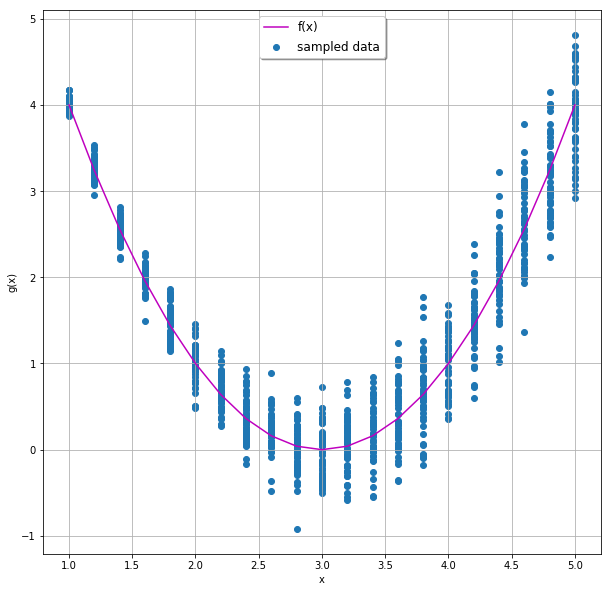

In [0]:
# https://engineering.taboola.com/predicting-probability-distributions/

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
def f(x):
    return x**2-6*x+9

def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 0 | cost = 6.6728
Epoch 50 | cost = 1.5710
Epoch 100 | cost = 0.3047
Epoch 150 | cost = 0.1939
Epoch 200 | cost = 0.1506
Epoch 250 | cost = 0.1286
Epoch 300 | cost = 0.1187
Epoch 350 | cost = 0.1124
Epoch 400 | cost = 0.1091
Epoch 450 | cost = 0.1126
Final cost: 0.1056


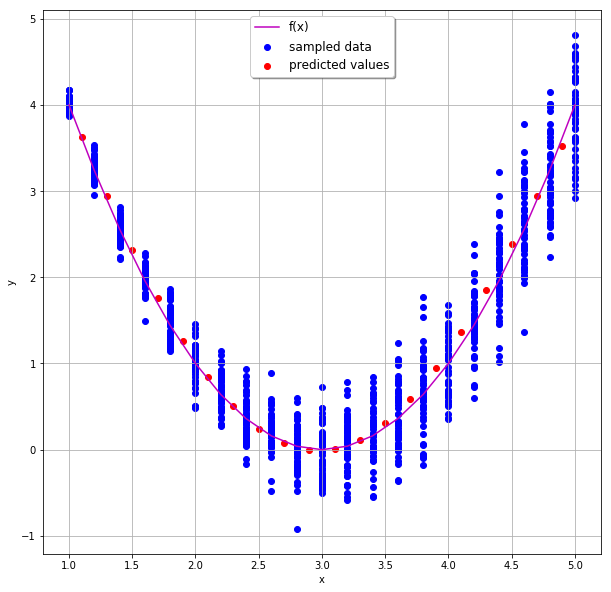

In [0]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for _ in range(3):
    layer = tf.layers.dense(inputs=layer, units=12, activation=tf.nn.tanh)
output = tf.layers.dense(inputs=layer, units=1)

cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=y,predictions=output))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        avg_cost = 0.0
        x_batches, y_batches = shuffle(x_batches, y_batches)
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    y_pred = sess.run(output,feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_test,y_pred,c='r',label='predicted values')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Epoch 0 | cost = 2.0183
Epoch 50 | cost = 1.5696
Epoch 100 | cost = 0.4592
Epoch 150 | cost = 0.3468
Epoch 200 | cost = 0.2817
Epoch 250 | cost = 0.2214
Epoch 300 | cost = 0.1817
Epoch 350 | cost = 0.1676
Epoch 400 | cost = 0.1466
Epoch 450 | cost = 0.1365
Final cost: 0.1413


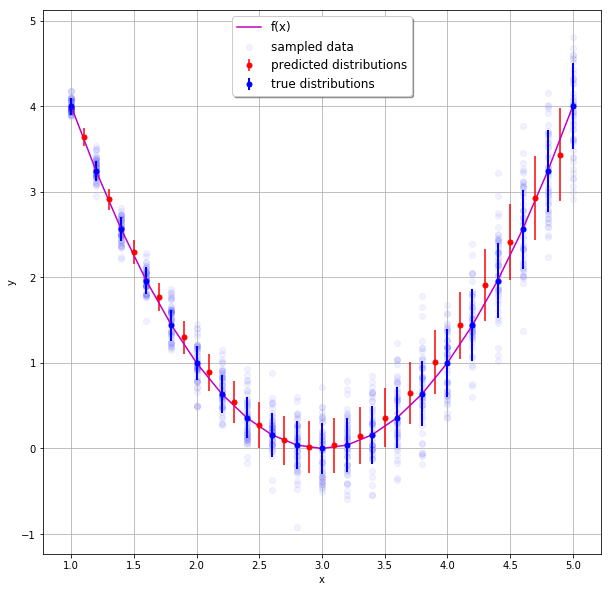

In [0]:
def mdn_cost(mu, sigma, y):
    dist = tf.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for _ in range(3):
    layer = tf.layers.dense(inputs=layer, units=12, activation=tf.nn.tanh)
mu = tf.layers.dense(inputs=layer, units=1)
sigma = tf.layers.dense(inputs=layer, units=1, activation=lambda x: tf.nn.elu(x) + 1)

cost = mdn_cost(mu, sigma, y)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        avg_cost = 0.0
        x_batches, y_batches = shuffle(x_batches, y_batches)
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    mu_pred, sigma_pred = sess.run([mu,sigma],feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()


##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Probabilistic Layers: Regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this example we show how to fit regression models using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [0]:
#@title Install { display-mode: "form" }
TF_Installation = 'TF2 Nightly (GPU)' #@param ['TF2 Nightly (GPU)', 'TF2 Stable (GPU)', 'TF1 Nightly (GPU)', 'TF1 Stable (GPU)','System']

if TF_Installation == 'TF2 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu-2.0-preview
  print('Installation of `tf-nightly-gpu-2.0-preview` complete.')
elif TF_Installation == 'TF2 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
  print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')
elif TF_Installation == 'TF1 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu
  print('Installation of `tf-nightly-gpu` complete.')
elif TF_Installation == 'TF1 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu
  print('Installation of `tensorflow-gpu` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

Installation of `tf-nightly-gpu-2.0-preview` complete.


In [0]:
#@title Install { display-mode: "form" }
TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

Installation of `tfp-nightly` complete.


In [0]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [0]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [0]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

Well not only is it possible, but this colab shows how! (In context of linear regression problems.)

In [0]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

### Case 1: No Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13275796
5.1289654


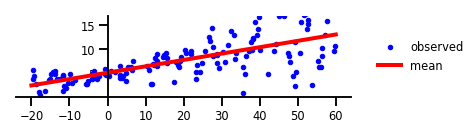

In [0]:
#@title Figure 1: No uncertainty.
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

### Case 2: Aleatoric Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.13226233 0.41329   ]
[5.1153    1.2915019]


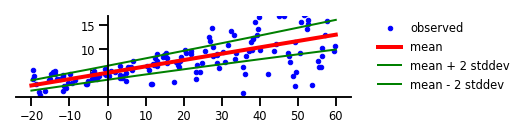

In [0]:
#@title Figure 2: Aleatoric Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

### Case 3: Epistemic Uncertainty

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.1374202  5.1056857 -3.7132006 -0.5256554]
[0.1592448 5.12206  ]


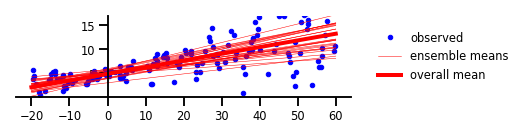

In [0]:
#@title Figure 3: Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

### Case 4: Aleatoric & Epistemic Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13091448  2.8183267   5.1185093   2.954348   -3.344546   -0.684905
 -0.5135757   0.05770317]
[0.13267924 2.7312424  5.191225   2.9794762 ]


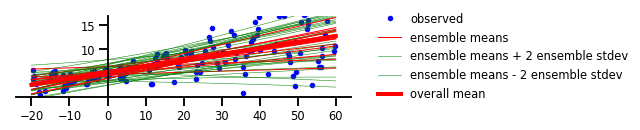

In [0]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

### Case 5: Functional Uncertainty

In [0]:
#@title Custom PSD Kernel
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [0]:
# Build model.
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1], dtype=x.dtype),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(dtype=x.dtype),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

W0514 13:06:56.457257 140574010046336 linear_operator.py:696] Using (possibly slow) default implementation of determinant.  Requires conversion to a dense matrix and O(N^3) operations.


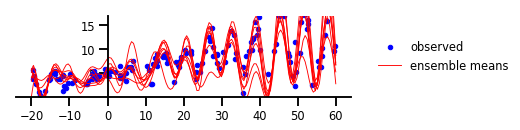

In [0]:
#@title Figure 5: Functional Uncertainty

y, x, _ = load_dataset()

plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

num_samples = 7
for i in range(num_samples):
  sample_ = yhat.sample().numpy()
  plt.plot(x_tst,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig5.png', bbox_inches='tight', dpi=300)